# Playground

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')
import sys
sys.path.append('/content/gdrive/MyDrive/generative-models-for-phenotypic-profiling')
%cd /content/gdrive/MyDrive/generative-models-for-phenotypic-profiling
%pwd

Mounted at /content/gdrive/
/content/gdrive/MyDrive/generative-models-for-phenotypic-profiling


'/content/gdrive/MyDrive/generative-models-for-phenotypic-profiling'

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

from typing import List, Set, Dict, Tuple, Optional, Any
from collections import defaultdict

import pandas as pd
import seaborn as sns
import numpy as np

import math 
import torch
from torch import nn, Tensor
from torch.nn.functional import softplus, relu
from torch.distributions import Distribution, Normal
from torch.utils.data import DataLoader, Dataset


from gmfpp.utils.data_preparation import *
from gmfpp.utils.data_transformers import *
from gmfpp.utils.plotting import *

from gmfpp.models.ReparameterizedDiagonalGaussian import *
from gmfpp.models.CytoVariationalAutoencoder import *
from gmfpp.models.VariationalAutoencoder import *
from gmfpp.models.ConvVariationalAutoencoder import *
from gmfpp.models.VariationalInference import *
from gmfpp.models.LoadModels import *

In [3]:
def constant_seed(seed: int = 0):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)

In [4]:
constant_seed()

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## Load data

In [6]:
data_root = "/content/gdrive/MyDrive/generative-models-for-phenotypic-profiling/data/two_from_each_moa/"
#data_root = "/content/gdrive/MyDrive/generative-models-for-phenotypic-profiling/two_multicells_two_moas/"
metadata_all = read_metadata(data_root + "metadata.csv")

mapping = get_MOA_mappings(metadata_all)

metadata = read_metadata(data_root + "metadata.csv")

metadata = shuffle_metadata(metadata)
metadata_train_all, metadata_test = split_metadata(metadata, split_fraction = .90)
metadata_train, metadata_validation = split_metadata(metadata_train_all, split_fraction = .90)

relative_path = get_relative_image_paths(metadata)
image_paths = [data_root + path for path in relative_path]
images = load_images(image_paths)

In [7]:
normalize_channels_inplace(images)
print(images.shape)

torch.Size([26, 3, 68, 68])


In [8]:
# VAE saved parameters

from gmfpp.models.LoadModels import *

vae, validation_data, training_data, VAE_settings = LoadVAEmodel("model_dump", '2022-11-22 - 22-54-08')

In [9]:
'''vae = vae.to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=VAE_settings['learning_rate'], weight_decay=VAE_settings['weight_decay'])

vi = VariationalInference(beta=VAE_settings['beta'])'''

"vae = vae.to(device)\noptimizer = torch.optim.Adam(vae.parameters(), lr=VAE_settings['learning_rate'], weight_decay=VAE_settings['weight_decay'])\n\nvi = VariationalInference(beta=VAE_settings['beta'])"

In [10]:
train_set = SingleCellDataset(metadata_train, images, mapping)
validation_set = SingleCellDataset(metadata_validation, images, mapping)
test_set = SingleCellDataset(metadata_test, images, mapping)

In [11]:
train_loader = DataLoader(train_set, batch_size=VAE_settings['batch_size'], shuffle=True, num_workers=0, drop_last=True)
validation_loader = DataLoader(validation_set, batch_size=VAE_settings['batch_size'], shuffle=False, num_workers=0, drop_last=False)

In [12]:
x0, _ = test_set[0]
x1, _ = test_set[1]

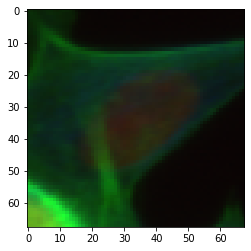

In [13]:
plot_image(x0)

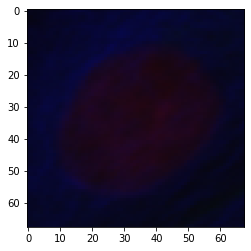

In [14]:
plot_image(x1)

In [15]:
vae.eval() # because of batch normalization
outputs0 = vae(x0[None,:,:,:])
px0 = outputs0["px"]

x0_reconstruction = px0.sample()
x0_reconstruction = x0_reconstruction[0]


outputs1 = vae(x1[None,:,:,:])
px1 = outputs1["px"]

x1_reconstruction = px1.sample()
x1_reconstruction = x1_reconstruction[0]

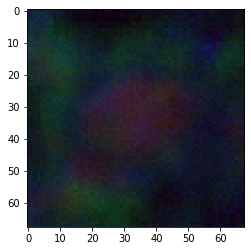

In [16]:
plot_image(x0_reconstruction)

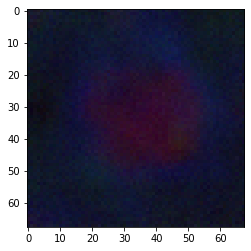

In [17]:
plot_image(x1_reconstruction)

In [45]:
z0 = outputs0["z"].detach().numpy()
z1 = outputs1["z"].detach().numpy()

## 10 new images from interpolated latent variables

In [47]:
# 10 set of latent variables from linear interpolations of the 2 images' latent variables
zs = np.linspace(z0, z1, num=10)
zs = torch.tensor(zs)
zs.shape

torch.Size([10, 1, 256])

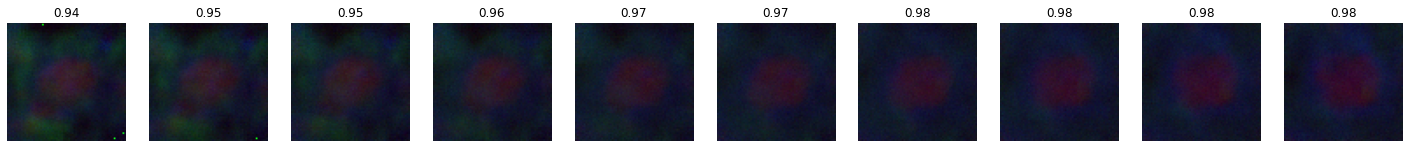

In [48]:
# calculating CosineSimilarity
cos = nn.CosineSimilarity(dim=1, eps=1e-6)

cp = []
for i in range(len(zs)):
  input1 = vae.observation_model(zs[i]).sample()[0]
  benchmark = vae.observation_model(zs[9]).sample()[0]
  cp.append(cos(input1, benchmark).mean().numpy().round(2))

# create figure
fig = plt.figure(figsize=(25, 10))

# setting values to rows and column variables
rows = 1
columns = len(zs)

# Adds a subplot at the 1st position

for i in range(columns):
  fig.add_subplot(rows, columns, i+1)
  plt.imshow((torch.permute(vae.observation_model(zs[i]).sample()[0], (1, 2, 0))* 255).numpy().astype(np.uint8))
  plt.axis('off')
  plt.title(cp[i])